In [6]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from typing import Dict, TypeAlias

base: str = "./datasets/"

In [7]:
# load transactions dataset
transactions = pd.read_csv(
    base + "transactions.csv",
    names=['timestamp', 'blockId', 'txId', 'isCoinbase', 'fee'],
    dtype={'timestamp': np.uint32, 'blockId': np.uint32, 'txId': np.uint32, 'isCoinbase': np.uint8},
)

# load input dataset
inputs = pd.read_csv(
    base + "inputs.csv",
    names=['txId', 'prevTxId', 'prevTxPos'],
    dtype={'txId': np.uint32, 'prevTxId': np.uint32, 'prevTxPos': np.uint16},
)

# load output dataset
outputs = pd.read_csv(
    base + "outputs.csv",
    names=['txId', 'txPos', 'addressId', 'amount', 'scriptType'],
    dtype={'txId': np.uint32, 'txPos': np.uint16, 'addressId': np.uint32, 'amount': np.uint64, 'scriptType': np.uint8}
)



# Script table
ScriptType: TypeAlias = np.uint8
ScriptSize: TypeAlias = np.uint16

scripts_dict: Dict[ScriptType, ScriptSize] = {0: 0, 1:153, 2:180, 3:291}

I dtypes per i DataFrame $transactions, inputs$, e $outputs$ sono stati scelti in modo tale da ottimizzare l'uso di memoria. 

Quelli default sono int64, ma per diverse colonne bastano 16 o 32 bit per rappresentare il range di valori possibili

# Analisi fee rispetto a congestione


In [8]:
transactions_ncb = transactions[transactions['isCoinbase'] == 0].drop(columns=['blockId', 'isCoinbase'])

# Merge transactions with inputs; then calculate size of inputs
merged_tx_inputs = pd.merge(transactions_ncb, inputs.drop(columns=['prevTxId', 'prevTxPos']), on='txId', how='inner')
size_inputs = merged_tx_inputs\
    .groupby('txId')\
    .size()\
    .reset_index(name='num_inputs')

# Merge transactions with outputs; then calculate size of outputs
merged_tx_outputs = pd.merge(transactions_ncb, outputs.drop(columns=['txPos', 'addressId']), on='txId', how='inner')
merged_tx_outputs['scriptSize'] = merged_tx_outputs['scriptType']\
    .replace(scripts_dict)

size_outputs = merged_tx_outputs\
    .groupby('txId')\
    .agg({'amount': 'count','scriptSize': 'sum'})\
    .reset_index()
size_outputs.rename(columns={'amount': 'num_outputs'}, inplace=True)


In [27]:
# Merge the sizes with transactions
merged_transactions = pd.merge(transactions_ncb, size_inputs, on='txId', how='left')
merged_transactions = pd.merge(merged_transactions, size_outputs, on='txId', how='left')

INPUT_SIZE = 40
OUTPUT_SIZE = 9

# Calculate size of each transaction
merged_transactions['transaction_size'] = merged_transactions['num_inputs'] * INPUT_SIZE + merged_transactions['num_outputs'] * OUTPUT_SIZE + merged_transactions['scriptSize']
merged_transactions.drop(
    columns=['num_inputs', 'num_outputs', 'scriptSize'],
    inplace=True)

# tt = transaction total (info needed)
tt = merged_transactions.groupby('timestamp').agg({'fee': 'mean', 'transaction_size': 'sum'}).reset_index()
tt.rename(
    columns={'fee': 'avgFee', 'transaction_size': 'congestion'},
    inplace=True)
tt["timestamp"] = pd.to_datetime(tt["timestamp"], unit="s")

print(tt.describe())

                           timestamp        avgFee    congestion
count                         130620  1.306200e+05  1.306200e+05
mean   2011-10-07 11:38:35.827545600  1.578124e+05  4.131758e+04
min              2009-01-12 03:30:25  0.000000e+00  2.020000e+02
25%    2011-03-15 13:24:22.750000128  0.000000e+00  2.977000e+03
50%              2011-09-29 11:53:29  4.602909e+04  1.190450e+04
75%       2012-05-24 12:06:59.500000  9.470804e+04  4.654425e+04
max              2012-12-31 23:52:37  1.718357e+09  2.464451e+06
std                              NaN  5.720015e+06  7.479096e+04


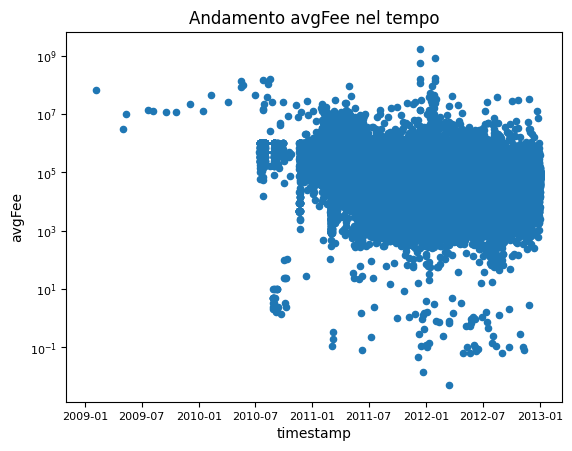

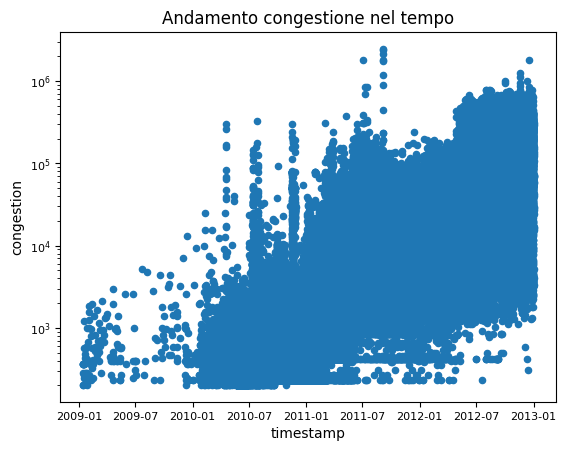

In [11]:
tt.plot.scatter(x='timestamp', y='avgFee', title='Andamento avgFee nel tempo', fontsize=8, logy=True)
tt.plot.scatter(x='timestamp', y='congestion', title='Andamento congestione nel tempo', fontsize=8, logy=True)
plt.show()

Come si nota dai grafici, nonostante nel tempo la congestione della blockchain sia aumentata di qualche ordine di grandezza, lo stesso non si può dire per la fee media. Nonostante alcuni outlier, generalmente è rimasta attorno all'ordine di grandezza di 10<sup>4</sup>

In [39]:
# heatmap
import seaborn as sns

tt = tt.resample('1ME', on='timestamp')\
    .agg({'avgFee': 'mean', 'congestion': 'mean'})\
    .reset_index()

In [40]:
# Bin the data
fee_bins = np.linspace(tt['avgFee'].min(), tt['avgFee'].max(), 10)
size_bins = np.linspace(tt['congestion'].min(), tt['congestion'].max(), 10)
tt['avgFee_binned'] = pd.cut(tt['avgFee'], bins=fee_bins)
tt['congestion_binned'] = pd.cut(tt['congestion'], bins=size_bins)

#print(tt)

/tmp/ipykernel_30412/2808540237.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table= tt\


<Axes: xlabel='congestion_binned', ylabel='avgFee_binned'>

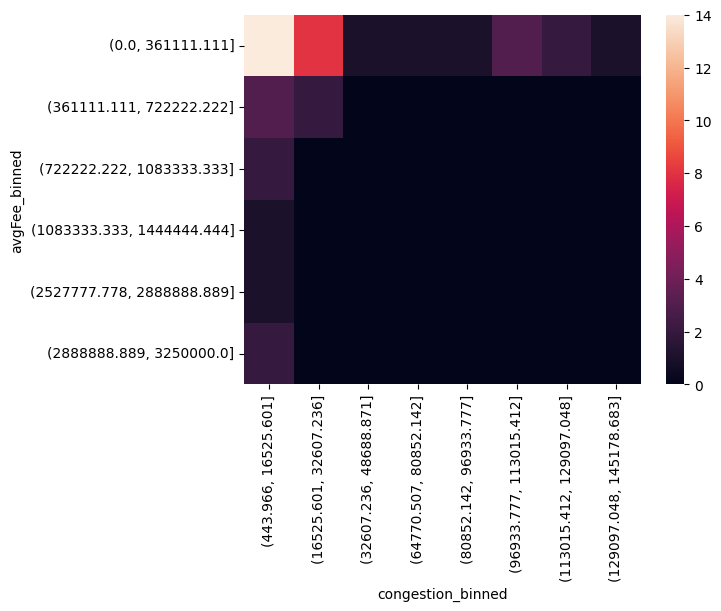

In [41]:
pivot_table= tt\
    .drop(columns=["timestamp", "avgFee", "congestion"])\
    .pivot_table(index='avgFee_binned', columns='congestion_binned', aggfunc=len, fill_value=0)

sns.heatmap(pivot_table)

In generale, non emerge alcuna correlazione significativa tra $avgFee$ e $congestion$. 

# Analisi script usati in transazioni

In [47]:
merged_tx_outputs = pd.merge(
    transactions.drop(columns=['blockId', 'fee', 'isCoinbase']), 
    outputs.drop(columns=['txPos', 'addressId', 'amount']), 
    on='txId', how='inner')

script_groups = merged_tx_outputs.pivot_table(index='timestamp', columns='scriptType', aggfunc='size', fill_value=0).reset_index()
script_groups.columns = ['timestamp', 'scriptType_0', 'scriptType_1', 'scriptType_2', 'scriptType_3']


script_groups['timestamp'] = pd.to_datetime(script_groups['timestamp'], unit='s')

# downsample df
script_groups = script_groups\
    .resample('24h', on='timestamp')\
    .sum().reset_index()


# Percentuali script

In [48]:
sc_pcg = script_groups
sc_pcg['total_count'] = sc_pcg[['scriptType_0', 'scriptType_1', 'scriptType_2', 'scriptType_3']].sum(axis=1)

# Calculate percentage of each script type
sc_pcg['scriptType_0_percent'] = (sc_pcg['scriptType_0'] / sc_pcg['total_count']) #* 100
sc_pcg['scriptType_1_percent'] = (sc_pcg['scriptType_1'] / sc_pcg['total_count']) #* 100
sc_pcg['scriptType_2_percent'] = (sc_pcg['scriptType_2'] / sc_pcg['total_count']) #* 100
sc_pcg['scriptType_3_percent'] = (sc_pcg['scriptType_3'] / sc_pcg['total_count']) #* 100

# Drop not needed column
sc_pcg = sc_pcg.drop(columns=['total_count', 'scriptType_0', 'scriptType_1', 'scriptType_2', 'scriptType_3'])

sc_pcg = sc_pcg.dropna()

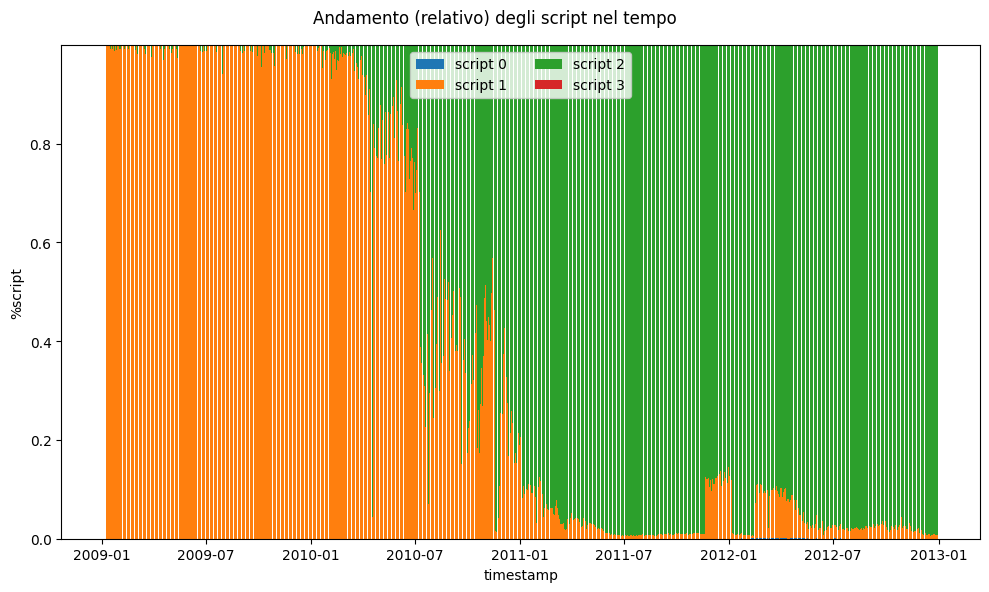

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed

ax.bar(sc_pcg['timestamp'], sc_pcg['scriptType_0_percent'], label='script 0')
ax.bar(sc_pcg['timestamp'], sc_pcg['scriptType_1_percent'], bottom=sc_pcg['scriptType_0_percent'], label='script 1')
ax.bar(sc_pcg['timestamp'], sc_pcg['scriptType_2_percent'], bottom=sc_pcg['scriptType_0_percent']+sc_pcg['scriptType_1_percent'], label='script 2')
ax.bar(sc_pcg['timestamp'], sc_pcg['scriptType_3_percent'], bottom=sc_pcg['scriptType_0_percent']+sc_pcg['scriptType_1_percent']+sc_pcg['scriptType_2_percent'], label='script 3')

ax.legend(loc='upper center', ncol=2)
fig.suptitle("Andamento (relativo) degli script nel tempo")
plt.xlabel("timestamp")
plt.ylabel("% script")
plt.tight_layout()  # Adjust layout to prevent overlapping labels
#plt.savefig(fname='script_time.png')
plt.show()

Come si osserva dal grafico, inizialmente la quasi totalità delle transazioni usava lo script di tipo 1, ma a partire da metà 2010, c'è stato un enorme switch a favore del tipo 2.

Nei primi anni, gli script di tipo 0 e 3 sono praticamente assenti. 

# Analisi delle Mining Pool

## Utils per scraping

In [136]:
import random
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from fake_useragent import UserAgent

In [137]:
# Funzione per estrazione dei proxy da sslproxies.org
def generate_proxies():
    ua = UserAgent() 
    
    proxies = []
    
    proxies_req = Request('https://www.sslproxies.org/')
    proxies_req.add_header('User-Agent', ua.random)
    proxies_doc = urlopen(proxies_req).read().decode('utf8')
    soup = BeautifulSoup(proxies_doc, 'html.parser')
    
    proxies_table = soup.find('table', class_='table table-striped table-bordered')
    
    # Salvo i proxy nella lista proxies
    for row in proxies_table.tbody.find_all('tr'):
        td = row.find_all('td')
        proxies.append(f'{td[0].string}:{td[1].string}')
    
    return proxies

In [138]:
def setup_driver(executable_path='/home/dan/Università/Info/3/LWS/progetto/geckodriver'):
    
    #rotate proxy ip
    proxies = generate_proxies()
    proxy_server_url = random.choice(proxies)
    
    options = Options()
    options.add_argument('--headless') #TODO: remove comment
    options.add_argument(f'--proxy-server={proxy_server_url}')
    options.add_argument(f'user-agent={UserAgent().random}')

    service = webdriver.FirefoxService(executable_path=executable_path)
    driver = webdriver.Firefox(service=service, options=options)

    return driver

Per evitare di essere bloccati dal sito, conviene ruotare proxy ed User Agent ad ogni nuovo collegamento

## Scraping degli indirizzi delle pool

In [54]:
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException

In [55]:
URL = 'https://www.walletexplorer.com'
pools = ['Eligius', 'DeepBit', 'BitMinter', 'BTCGuild']

addresses = []

driver = setup_driver()
driver.get(URL)

In [56]:
for pool in pools:
    text_input = driver.find_element(By.XPATH, '/html/body/div[2]/form/p/label/input')
    search_button = driver.find_element(By.XPATH, '/html/body/div[2]/form/p/input')
    
    text_input.send_keys(pool)
    search_button.click()

    driver.implicitly_wait(5)
    viewAddress = driver.find_element(By.CSS_SELECTOR, '.showother > a:last-child')
    viewAddress.click()


    pages = driver\
        .find_element(By.XPATH, '/html/body/div[2]/div[1]')\
        .text.split(' ')
    
    totPages = int(pages[5])

    if totPages != 1:
        currentPage = 1

        while(currentPage < totPages):
            #print(f'curr: {currentPage}')
            
            # scrape addresses
            rows = driver.find_elements(By.TAG_NAME, 'tr')[1:]
            addresses += [{'pool': pool, 'address': row.find_element(By.XPATH, 'td[1]').text} for row in rows]
            
            # go to next page
            driver.implicitly_wait(5)
            try:
                nextButton = driver.find_element(By.XPATH, '//a[text()="Next…"]')
                nextButton.click()
            except NoSuchElementException:
                break

            currentPage += 1

        #print('out of while')
        driver.implicitly_wait(3)
        lastButton = driver.find_element(By.XPATH, '/html/body/div[2]/div[1]/a[3]')
        lastButton.click()

        rows = driver.find_elements(By.TAG_NAME, 'tr')[1:]
        addresses += [{'pool': pool, 'address': row.find_element(By.XPATH, 'td[1]').text} for row in rows]


    driver.implicitly_wait(5)

    homeAnchor = driver.find_element(By.XPATH, '/html/body/div[1]/h1/a')
    homeAnchor.click()

    #TODO: longer wait

driver.quit()

In [57]:
addressDf = pd.DataFrame.from_records(addresses, columns=['pool', 'address'])
addressDf.to_csv('poolAddresses.csv', index=False, header=False)

# Wallet scraping

In [58]:
Address: TypeAlias = str
Wallet: TypeAlias = str


def get_wallet(addresses: list[Address]) -> Dict[Address, Wallet]:
    URL = 'https://www.walletexplorer.com'
    wallet = {}

    driver = setup_driver()
    driver.get(URL)

    for address in addresses:
        text_input = driver.find_element(By.XPATH, '/html/body/div[1]/form/input[1]')
        search_button = driver.find_element(By.XPATH, '/html/body/div[1]/form/input[2]')

        text_input.send_keys(address)
        search_button.click()

        driver.implicitly_wait(5)
        h2 = driver.find_element(By.XPATH, '/html/body/div[2]/h2')
        wallet_id = h2.text.split(' ')[1].replace('[', '').replace(']', '')
        
        wallet.update({address: wallet_id})

    driver.quit()
    return wallet

# Part 2

In [68]:
# load output dataset
mappings = pd.read_csv(
    base + "mappings.csv",
    names=['address', 'addressId'],
    dtype={'address': pd.StringDtype(), 'addressId': np.uint32}
)


# load pool dataset
pool = pd.read_csv(
    "poolAddresses.csv",
    names=['pool', 'address'],
    dtype={'pool': pd.StringDtype(), 'address': pd.StringDtype()}
)

In [69]:
#get all coinbases
transactions_cb = transactions[transactions['isCoinbase'] == 1]\
    .drop(columns=['isCoinbase', 'fee'])    # max fee == 0 => drop 'fee'

merged_tx_output = pd.merge(transactions_cb, outputs, on='txId')\
    .drop(columns=['txPos'])

In [70]:
# associate pool with address (or better, id) of transactions 
merged_pool_id = pd.merge(pool, mappings, on='address')\
    .drop('address', axis=1)

# assert no double (address <-> pool) relation
assert merged_pool_id['addressId'].unique().size == len(merged_pool_id.index)

# Deanonymize miner pools

In [71]:
# de-anonymize
deanonymized_tx = pd.merge(merged_tx_output, merged_pool_id, on='addressId', how='left')
deanonymized_tx.fillna(value='Other', inplace=True)

assert len(deanonymized_tx.index) == len(merged_tx_output.index)

## Top 4 miners

In [72]:
#find top 4 miners
others = deanonymized_tx[deanonymized_tx['pool'] == 'Other']

addressTxCount = others.groupby('addressId')\
    .agg(txCount=('txId', 'size'))\
    .reset_index()

assert len(addressTxCount.index) == others["addressId"].unique().size
assert addressTxCount['txCount'].sum() == len(others.index)

In [73]:
top4Miner = addressTxCount.nlargest(4, 'txCount')\
    .merge(mappings, on='addressId')\
    .drop(columns=['addressId'])

top4MinerAddresses: np.ndarray = top4Miner['address'].to_numpy()

addr_wallets: Dict[Address, Wallet] = get_wallet(list(top4MinerAddresses))

# convert address to addressId
id_wallets = {}    #Dict<AddressId, Wallet>

for addr, wallet in addr_wallets.items():
    id = mappings[mappings['address'] == addr]
    id_wallets.update({id['addressId'].values[0]: wallet})

In [74]:
# update deanonymized_tx with top4 miner wallet
def update_pool(row):
    if row['addressId'] in id_wallets:
        return id_wallets[row['addressId']]
    else:
        return row['pool']

deanonymized_tx['pool'] = deanonymized_tx.apply(update_pool, axis=1)

# Analizzare le Coinbase deanonimizzate

In [75]:
interest_df = deanonymized_tx[deanonymized_tx['pool'] != 'Other']\
    .drop(columns=['txId', 'addressId', 'scriptType'])

nBlocks_grouped = interest_df\
    .groupby('pool')\
    .agg({'blockId': 'size', 'amount': 'sum'})\
    .reset_index()

nBlocks_grouped.columns = ['pool', 'blockCount', 'totalAmount']


# controllo: non si sono perse righe
assert nBlocks_grouped['blockCount'].sum() == len(interest_df.index)
assert nBlocks_grouped['totalAmount'].sum() == interest_df['amount'].sum()

## Statistiche globali di blocchi minati e ricompense

In [78]:
print(nBlocks_grouped)

                pool  blockCount     totalAmount
0         019a46b8d8        1741   8713619305387
1         01a990df75        1738   7416681029411
2         3e486bf1d3        2587  12696869155524
3           BTCGuild        1162   4203649145799
4          BitMinter        2024   9413281313194
5  EclipseMC.com-old        1919   8772777983863
6            Eligius        1439    671414768803


In [82]:
#Ricavare percentuali di blocchi e ricompense
total_block = nBlocks_grouped['blockCount'].sum()
total_amount = nBlocks_grouped['totalAmount'].sum()

nBlocks_grouped_pcg = nBlocks_grouped.drop(columns=['blockCount', 'totalAmount'])
nBlocks_grouped_pcg['blockPct'] = (nBlocks_grouped['blockCount'] / total_block) * 100
nBlocks_grouped_pcg['amountPct'] = (nBlocks_grouped['totalAmount'] / total_amount) * 100

print(nBlocks_grouped_pcg)

                pool   blockPct  amountPct
0         019a46b8d8  13.806503  16.793035
1         01a990df75  13.782712  14.293554
2         3e486bf1d3  20.515464  24.469622
3           BTCGuild   9.214909   8.101344
4          BitMinter  16.050753  18.141436
5  EclipseMC.com-old  15.218081  16.907047
6            Eligius  11.411578   1.293962


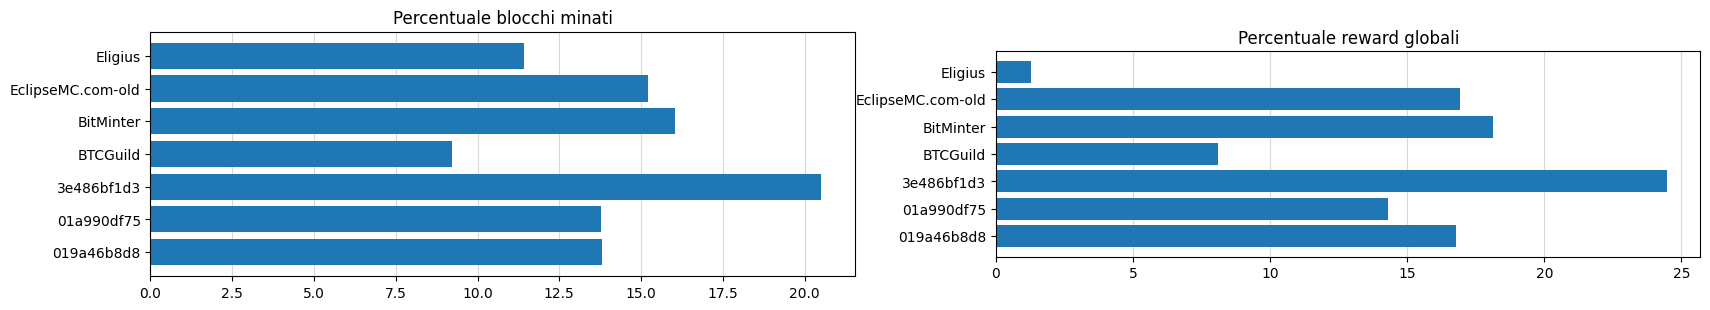

In [77]:
figH, axsH = plt.subplots(1, 2, figsize=(20, 15))

axsH[0].grid(axis='x', alpha=0.5, zorder=0)
axsH[0].barh(nBlocks_grouped_pcg['pool'], nBlocks_grouped_pcg['blockPct'], zorder=2)
axsH[0].set_title('Percentuale blocchi minati')
axsH[0].set_aspect('equal')

axsH[1].grid(axis='x', alpha=0.5, zorder=0)
axsH[1].barh(nBlocks_grouped_pcg['pool'], nBlocks_grouped_pcg['amountPct'], zorder=2)
axsH[1].set_title('Percentuale reward globali')
axsH[1].set_aspect('equal')

Quello che emerge subito è la dispartià tra blocchi minati e ricompensa ottenuta da $Eligius$: nonostante abbia minato circa 11% dei blocchi, ha ottenuto meno del 2% delle ricompense distribuite

Inoltre emerge anche che nell'intervallo di tempo considerato, non vi sono blocchi minati dalla pool $DeepBit$.

## Andamenti nel tempo di blocchi minati e ricompense

In [83]:
#timestamp -> date
interest_df['timestamp'] = pd.to_datetime(interest_df['timestamp'], unit='s')

Per dare una significatività all'andamento nel tempo, conviene vedere blocchi minati e ricompense su una scala temporale più lunga.
Per questo si effetua un downsample su intervalli di 1 mese.

In [84]:
downsampled_df = pd.DataFrame()

for p in nBlocks_grouped['pool']:
    df = interest_df[interest_df['pool'] == p]\
    .resample('1ME', on='timestamp')\
    .agg({'blockId': 'count', 'amount': 'sum'})\
    .reset_index()

    df['pool'] = p

    downsampled_df = pd.concat([downsampled_df, df])


downsampled_df = downsampled_df.rename(columns={"blockId": "blockCount"})
downsampled_df = downsampled_df.reset_index(drop=True)
downsampled_df.sort_values(by="timestamp", inplace=True)

In [85]:
grouped = downsampled_df\
    .groupby(['timestamp', 'pool'])\
    .sum().reset_index()

# Pivot the data to get 'pool' as columns, 'timestamp' as index, and 'amount' as values
pivot_amounts_df = grouped\
    .pivot(index='timestamp', columns='pool', values='amount')\
    .fillna(0)

# Pivot the data to get 'pool' as columns, 'timestamp' as index, and 'blockCount' as values
pivot_blocks_df = grouped\
    .pivot(index='timestamp', columns='pool', values='blockCount')\
    .fillna(0)

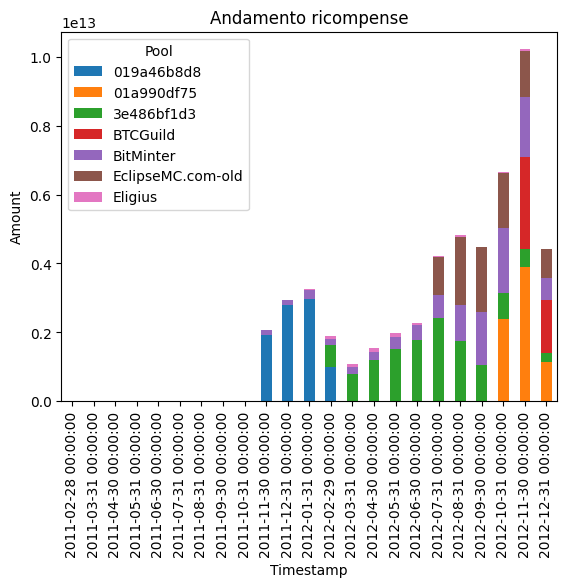

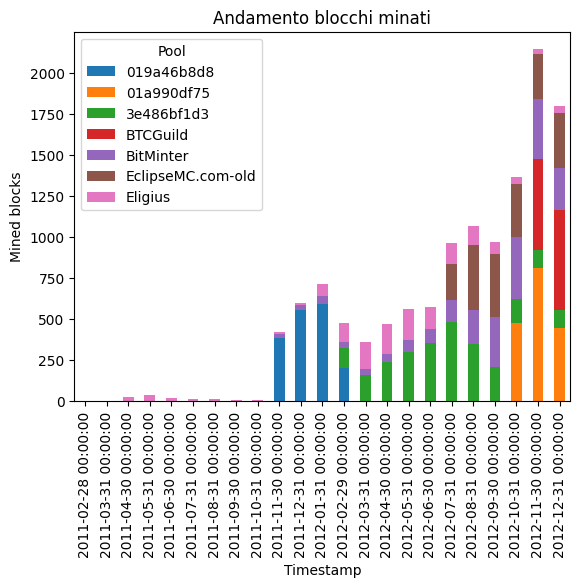

In [86]:
# Plot stacked bar chart for amount
pivot_amounts_df.plot(kind='bar', stacked=True)

# Customize the plot
plt.title('Andamento ricompense')
plt.xlabel('Timestamp')
plt.ylabel('Amount')
plt.legend(title='Pool')


# Plot stacked bar chart for blocks
pivot_blocks_df.plot(kind='bar', stacked=True)

# Customize the plot
plt.title('Andamento blocchi minati')
plt.xlabel('Timestamp')
plt.ylabel('Mined blocks')
plt.legend(title='Pool')

plt.show()

Emerge una divisione temporale. Nel 2011 blocchi e ricompense erano detenuti dal wallet  019a46b8d8; ad inizio 2012 si assiste ad un dominio relativo di 3e486bf1d3, mentre sul finire del 2012 c'è un bilanciamento tra le parti

# Part 3

In [134]:
import time
from typing import List

from matplotlib import pyplot as plt
import numpy as np

from selenium.webdriver.remote.webelement import WebElement

import networkx as nx

In [185]:
from dataclasses import dataclass

@dataclass
class TransactionRecord:
    nextAddress: str
    amount: float
    currentTxId: str
    nextTxId: str

In [210]:
ID_START = 'c82c10925cc3890f1299'
URL = 'https://www.walletexplorer.com'

# create graph
g: nx.MultiDiGraph = nx.MultiDiGraph()
K: int = 5

driver = setup_driver()
driver.get(URL)

In [197]:
def elaborateOutput(lst: List[WebElement], current_id: str) -> List[TransactionRecord]:
    '''
    Derive info of a given row; a row is an output for a transaction    
    '''
    
    res: List[TransactionRecord] = []
    for we in lst:
        # Make omogeneous structure: [num_output, nextAddress, wallet, amount, _, next_txid, _]
        tokens = we.text.split(' ')

        if tokens[2] == '(change':
            tokens.remove('(change')
        if tokens.__contains__(''):
            tokens = [t for t in tokens if t != '']

        # Ignore UTXO
        if tokens.__contains__('unspent'):
            continue
        
        #print(f"tokens: {tokens}")
        
        full_txid = we.find_element(By.PARTIAL_LINK_TEXT, tokens[5])\
            .get_dom_attribute('href')\
            .replace('/txid/', '')
        
        to: TransactionRecord = {'nextAddress': tokens[1], 'amount': float(tokens[3]), 'currentTxId': current_id, 'nextTxId': full_txid}
        res.append(to)

    return res

In [208]:
def recursiveTransactionPath(driver, ID: str, N: int, g: nx.DiGraph, address='CB'):
    if(N == 0):
        return 
    
    # go to tx_id=ID page 
    try:
        text_input = driver.find_element(By.XPATH, '/html/body/div[1]/form/input[1]')
        search_button = driver.find_element(By.XPATH, '/html/body/div[1]/form/input[2]')

        text_input.clear()
        text_input.send_keys(ID)
        search_button.click()
        #print(f'Actually at tx_id: {ID}')        
    except NoSuchElementException:
        print('Error with text bar or search button')
        return 
    
    g.add_node(ID, color=N, address=address)

    try:
        driver.implicitly_wait(7)

        outputs_rows = driver\
            .find_element(By.XPATH, '/html/body/div[2]/table[2]/tbody/tr[2]/td[2]/table/tbody')\
            .find_elements(By.TAG_NAME, 'tr')
    except NoSuchElementException:
        print(f'Can\'t find tr @<Id: {ID}>')
        return

    outputs: List[TransactionRecord] = elaborateOutput(outputs_rows, ID)

    for d in outputs:
        #g.add_node(d['nextTxId'], color=N-1, address=d['nextAddress'])
        #g.add_edge(ID, d['nextTxId'], weight=d['amount'])
        
        g.add_node(d['nextAddress'], color=N-1, address=d['nextAddress'])
        g.add_edge(address, d['nextAddress'], weight=d['amount'])


        time.sleep(5)
        recursiveTransactionPath(driver, d['nextTxId'], N-1, g, d['nextAddress'])

In [211]:
recursiveTransactionPath(driver, ID_START, K, g)
driver.quit()

### Graph drawing

In [212]:
# scale range [a, b] to [c, d]
# xscaled = c + (x−a) * (d−c) / (b−a)

def scale_list(lst, new_min, new_max):
    res = []

    old_delta = max(lst) - min(lst)
    new_delta = new_max - new_min

    for i in range(0, len(lst)):
        rescaled_value = new_min + (lst[i] - min(lst)) * (new_delta / old_delta)
        res.append(rescaled_value)

    return res

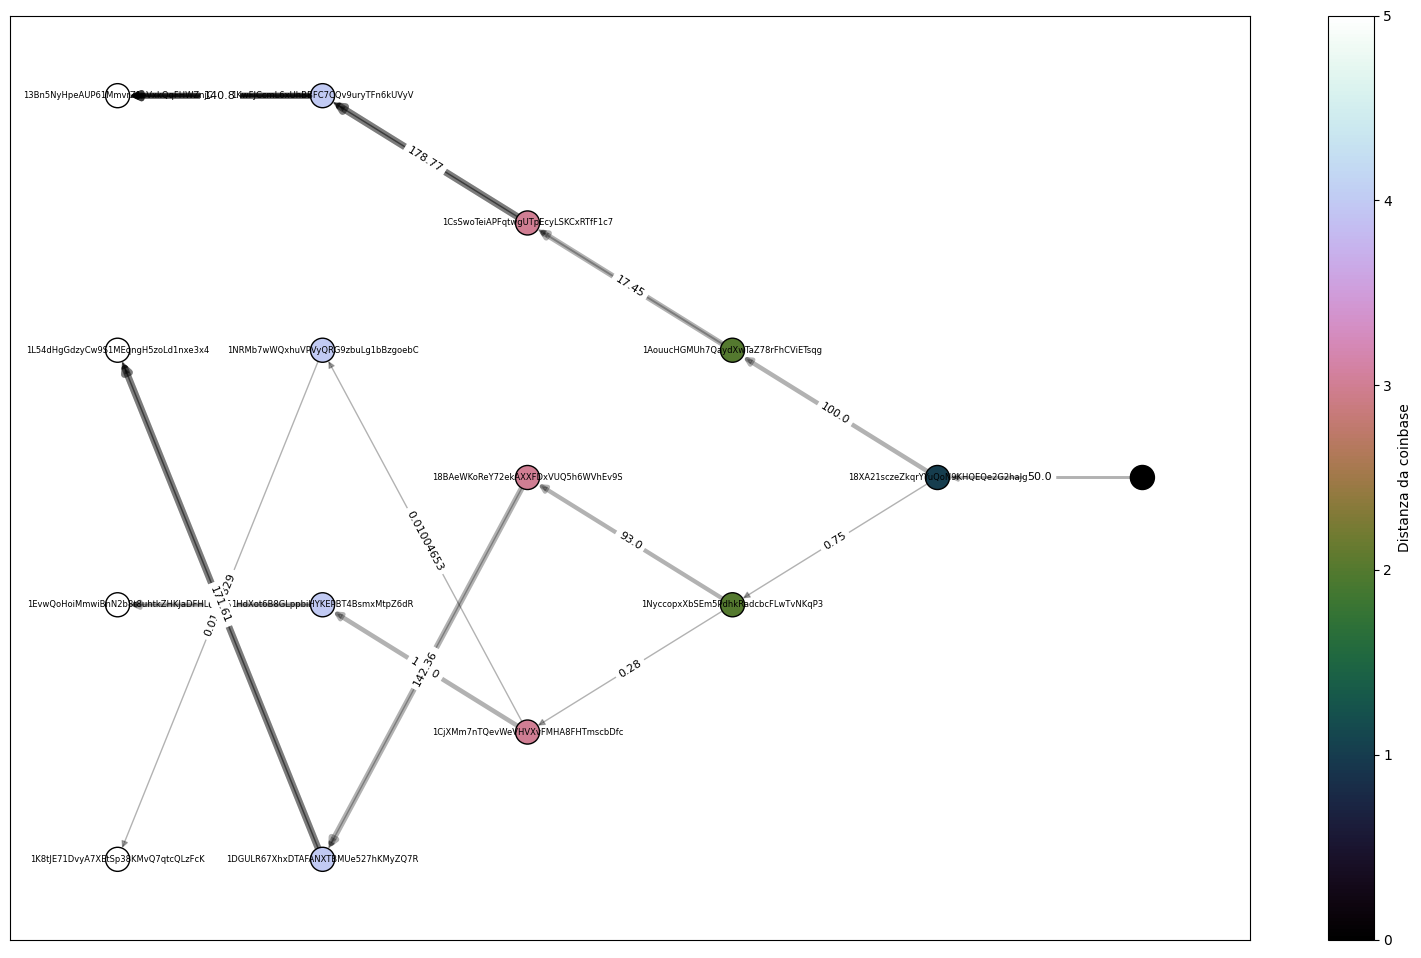

In [203]:
pos = nx.multipartite_layout(g, subset_key='color')
plt.figure(figsize=(20, 12))
node_colors = [abs(node[1]['color'] - K) for node in g.nodes(data=True)]

edge_widths = [edge[2]['weight'] for edge in g.edges(data=True)]
scaled_weights = scale_list(edge_widths, 1, 5)

ec = nx.draw_networkx_edges(g, pos, alpha=0.3, width=scaled_weights)
nc = nx.draw_networkx_nodes(g, pos, nodelist=g.nodes(), node_color=node_colors, cmap=plt.get_cmap('cubehelix'), edgecolors='black')

# node labels
node_labels = {node[0]:node[1]['address']for node in g.nodes(data=True)}
nx.draw_networkx_labels(g, pos, node_labels, font_size=6)


#edge labels
edge_amount = {(edge[0], edge[1]): edge[2]['weight'] for edge in g.edges(data=True)}
nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_amount, font_size=8)

plt.colorbar(nc, label="Distanza da coinbase", ax=plt.gca())

Fra i vari layout disponibili ho scelto un multipartite_layout. Questo layout consiste in diverse colonne quante sono le partizioni del grafo: la distanza dalla coinbase considerata rappresenta una partizione adatta al caso.
Trattandosi di un multigrafo, sono catturati anche i casi in cui più archi sono rivolti verso lo stesso indirizzo. Tuttavia sono rappresntati come sovrapposti.  

I nodi rappresentano gli address di arrivo delle transazioni, mentre gli archi hanno come peso il numero di bitcoin coinvolti. 
Non sono riportati gli UTXO.


Il layout presenta un problema di leggiblità. Infatti l'implementazione data dalla libreria non minimizza il numero di archi che si incrociano e non separa gli archi paralleli.

Una possibile soluzione sarebbe l'uso di uno shell layout (cerchi concentrici). Il partizionamento sarebbe lo stesso, ma diventa problematico trovare e posizionare correttamente tutti i vicini di un nodo.

In generale NetworkX non si presenta come uno strumento adatto alla visualizzazione di grafi, ma alla loro analisi. Pertanto la soluzione ottima sarebbe esportare il grafo ad un formato adatto a strumenti per $graph$ $visualization$ (come Gephi).

# Degree distribution

num_ending_nodes: 18
Mean degree: 2.142857142857143


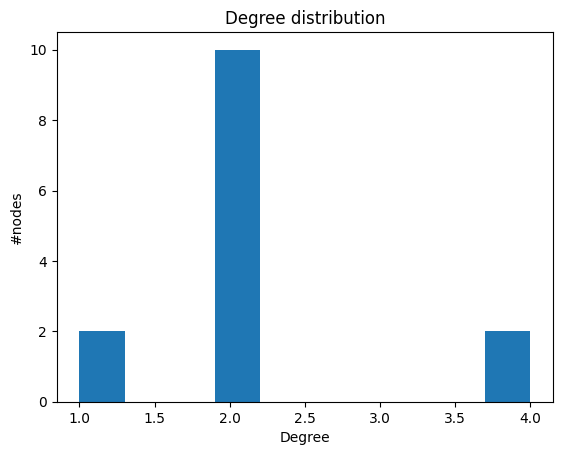

In [214]:
node_degrees = dict(g.out_degree())
values = list(node_degrees.values())

# remove ending points (out_degree == 0)
num_ending_nodes = 0
while(0 in values):
    values.remove(0)
    num_ending_nodes += 1

print(f"num_ending_nodes: {num_ending_nodes}")

meanDegree = np.mean(values)
print(f'Mean degree: {meanDegree}')


# plotting distribution
plt.figure()
plt.hist(values)

plt.title("Degree distribution")
plt.xlabel("Degree")
plt.ylabel("#nodes")

plt.show()

Per K=5, risulta un grado medio di 2.14, ovvero ci sono diversi nodi più output. In particolare la media è portata aatni da qualche nodo con grado 4.